# Optic flow connectivity analysis in FAFB

This script is about getting optic flow vectors in the medulla based on the main inputs of direction-selective (DS) T4 cells.
In a nutshell, it...
1. loads raw data from .csv.gz files, originally stored in the download section of Codex
2. organizes the data before grid creation
3. generates the 2D grid/lattice structure
4. plots the regular and hexagonal (honeycomb-like) grids using columnar coordinates in the medulla
5. plots and quantifies optic flow data on each type of grid/lattice

In [1]:
# Importing some packages
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import math
import numpy as np
import pandas as pd
import seaborn as sns
import os
from fafbseg import flywire
from scipy.stats import gaussian_kde
from helper import calculate_new_p_values, rotate_point,  add_space_in_between, add_space_in_between_2, getting_correlators_start_end_coordinates, getting_correlators_angles, get_input_fractions_and_norm, get_weighted_correlator
from helper import plot_hex_grid, draw_vector, color_hexagons_reference_axes,draw_correlator_vectors

C:\Users\smolina\Anaconda3\envs\EM2\lib\site-packages\blessed\terminal.py:183: UserWarning: Failed to setupterm(kind='xterm-color'): Could not find terminal xterm-color
  warnings.warn(msg)


# 1. Getting the data of interest

In [2]:
# Some user parameters
cell_for_grid = 'Mi1'

In [3]:
# Importing data from Codex
dataPath = R'D:\Connectomics-Data\FlyWire\Codex-datasets'
fileName = 'ol_columns.csv.gz'
filePath = os.path.join(dataPath,fileName)
columns_id_data = pd.read_csv(filePath, compression='gzip')
columns_id_data.rename(columns={"cell id": "root_id","cell type": "cell_type","column id": "column_id" }, inplace= True)

dataPath = R'D:\Connectomics-Data\FlyWire\Codex-datasets'
fileName = 'ol_metadata.csv.gz'
filePath = os.path.join(dataPath,fileName)
metadata = pd.read_csv(filePath, compression='gzip')

dataPath = R'D:\Connectomics-Data\FlyWire\Codex-datasets'
fileName = 'ol_connections.csv.gz'
filePath = os.path.join(dataPath,fileName)
ol_connections = pd.read_csv(filePath, compression='gzip')
ol_connections.rename(columns={"from cell id": "from_cell_id","to cell id": "to_cell_id" }, inplace= True)

dataPath = R'D:\Connectomics-Data\FlyWire\Codex-datasets'
fileName = 'column_assignment.csv.gz'
filePath = os.path.join(dataPath,fileName)
columns_id_coordinates = pd.read_csv(filePath, compression='gzip')

#Brief overview:
print('\n----------------- column data -----------------:\n')
print(columns_id_data)

print('\n------------------ metadata ------------------:\n')
print(metadata)
print('\n----------------- ol_connections ----------------:\n')
print(ol_connections)
print('\n----------------- coordinates ----------------:\n')
print(columns_id_coordinates)


----------------- column data -----------------:

                  root_id cell_type column_id
0      720575940596125868       T5c        97
1      720575940599333574       Tm1       355
2      720575940599457990       T4b       247
3      720575940599459782       T5b       513
4      720575940599704006       T5a       331
...                   ...       ...       ...
23447  720575940661201025        R8       701
23448  720575940661224065       T4a       390
23449  720575940661245825        C3       183
23450  720575940661264001        C3        38
23451  720575940661284993        R8       694

[23452 rows x 3 columns]

------------------ metadata ------------------:

                 attribute    value
0   number of cells mapped    22578
1  synapses inside columns  1381915
2   synapses cross columns   811545

----------------- ol_connections ----------------:

              from_cell_id          to_cell_id  synapses
0       720575940596125868  720575940622955561         2
1       72

In [4]:
# Discalimer: there are some T cells which have no "home" column_id assigned. Look this and compare numbers:
print('Total number of T4 cells:')
print(len(columns_id_data[columns_id_data.cell_type.isin(['T4a','T4b','T4c','T4d'])].root_id.unique()))
print('Total number of T4 cells assigned to a column:')
print(len(columns_id_coordinates[columns_id_coordinates.type.isin(['T4a','T4b','T4c','T4d'])].root_id.unique()))

Total number of T4 cells:
3103
Total number of T4 cells assigned to a column:
2998


## 1.1 Combining the data of interest into useful data frames

In [5]:
## Completing the "ol_connections" data frame
# Adding cell type names and their columns ids

ol_connections_extended = ol_connections.copy()

# Merge to add from_cell_type
ol_connections_extended = ol_connections_extended.merge(
    columns_id_data[['root_id', 'cell_type','column_id']],
    how='left',
    left_on='from_cell_id',
    right_on='root_id'
).rename(columns={'cell_type': 'from_cell_type','column_id': 'from_column_id'}).drop(columns=['root_id'])

# Merge to add to_cell_type
ol_connections_extended = ol_connections_extended.merge(
    columns_id_data[['root_id', 'cell_type','column_id']],
    how='left',
    left_on='to_cell_id',
    right_on='root_id'
).rename(columns={'cell_type': 'to_cell_type','column_id': 'to_column_id'}).drop(columns=['root_id'])

# Display the updated ol_connections data frame
display(ol_connections_extended)

# Print
print('\nAvailable cell types with column id data:')
print(ol_connections_extended.from_cell_type.unique())

,from_cell_id,to_cell_id,synapses,from_cell_type,from_column_id,to_cell_type,to_column_id
0,720575940596125868,720575940622955561,2,T5c,97,T5c,443
1,720575940599333574,720575940617904614,7,Tm1,355,T2a,238
2,720575940599333574,720575940629129692,22,Tm1,355,T3,641
3,720575940599333574,720575940612157041,11,Tm1,355,Tm4,394
4,720575940599333574,720575940609269771,4,Tm1,355,T2a,615
...,...,...,...,...,...,...,...
270851,720575940661264001,720575940613285034,3,C3,38,T2,409
270852,720575940661264001,720575940647104291,87,C3,38,L2,38
270853,720575940661264001,720575940638965155,17,C3,38,Tm4,38
270854,720575940661284993,720575940628173394,3,R8,694,L1,694



Available cell types with column id data:
['T5c' 'Tm1' 'T4b' 'T5b' 'T5a' 'T4a' 'Tm9' 'Mi9' 'T4c' 'T5d' 'T4d' 'Tm3'
 'T3' 'T2a' 'L1' 'T2' 'Mi4' 'Mi1' 'Tm2' 'Tm4' 'C2' 'L4' 'Tm20' 'L5' 'C3'
 'Tm21' 'L3' 'L2' 'R7' 'T1' 'R8']


# 2. Organizing the data before grid creation

## 2.1 Getting the cells of reference (usually Mi1s) for creating a 2D lattice

In [6]:
# Looking deeply at the match between individual cells and individual columns
cells_columns = columns_id_data[columns_id_data['cell_type'] == cell_for_grid]
number_unique_cells = len(cells_columns['root_id'].unique())
if 'not assigned' in cells_columns['column_id'].unique():
    number_unique_columns = len(cells_columns['column_id'].unique())-1 #-1 to compensate for "not assigned label" of some cells
else:
    number_unique_columns = len(cells_columns['column_id'].unique())
    

print(f'Total number of unique cells: {number_unique_cells}')
print(f'Total number of unique columns: {number_unique_columns}')
print(f'Missmatch: {number_unique_cells - number_unique_columns}')

# Identify duplicate values in 'column id'
duplicates = cells_columns[cells_columns.duplicated('column_id', keep=False)]

print(f'Number of duplicates / cells not assigned to columns: {len(duplicates)}')

# Filter out rows with repetitive values
filtered_cells_columns = cells_columns[~cells_columns['column_id'].isin(duplicates['column_id'])]
print(f'Filtered data length: {len(filtered_cells_columns)}')

# Addining column coordinates information
df_grid =  pd.merge(filtered_cells_columns, columns_id_coordinates[['root_id', 'p', 'q', 'x', 'y']], on='root_id', how='left')
print(f'Final df_grid length: {len(df_grid)}')
display(df_grid.head())

Total number of unique cells: 796
Total number of unique columns: 796
Missmatch: 0
Number of duplicates / cells not assigned to columns: 0
Filtered data length: 796
Final df_grid length: 796


,root_id,cell_type,column_id,p,q,x,y
0,720575940603042272,Mi1,1,12,1,6,13
1,720575940603200428,Mi1,2,9,-7,8,2
2,720575940603327916,Mi1,3,-12,0,-6,-12
3,720575940603935334,Mi1,4,-6,-15,5,-21
4,720575940604151008,Mi1,6,0,-4,2,-4


## 2.2 Looking at the cells of interest (T4 subtypes)

This is just data exploration. It is not needed for subsequent steps of analysis and plot

In [7]:
# Define the list of cells of interest
cells_of_interest_list = ['T4a', 'T4b', 'T4c', 'T4d']

# Initialize empty DataFrames to accumulate data
accumulated_df = pd.DataFrame()
accumulated_ol_connections = pd.DataFrame()
accumulated_duplicates = pd.DataFrame()

# Initialize counters
total_unique_cells = 0
total_unique_columns = 0
total_missmatch = 0
total_duplicates = 0

# Loop through each cell of interest and accumulate data
for cell_of_interest in cells_of_interest_list:
    print(f'\nProcessing cell of interest: {cell_of_interest}\n')

    # Looking deeply at the match between individual cells and individual columns
    cells_columns = columns_id_data[columns_id_data['cell_type'] == cell_of_interest]
    number_unique_cells = len(cells_columns['root_id'].unique())
    
    if 'not assigned' in cells_columns['column_id'].unique():
        number_unique_columns = len(cells_columns['column_id'].unique()) - 1  # Adjust for 'not assigned'
    else:
        number_unique_columns = len(cells_columns['column_id'].unique())

    missmatch = number_unique_cells - number_unique_columns

    # Update the overall counts
    total_unique_cells += number_unique_cells
    total_unique_columns += number_unique_columns
    total_missmatch += missmatch

    # Identify and accumulate duplicate values in 'column id'
    duplicates = cells_columns[cells_columns.duplicated('column_id', keep=False)]
    accumulated_duplicates = pd.concat([accumulated_duplicates, duplicates])
    total_duplicates += len(duplicates)

    # Filter out rows with repetitive values
    filtered_cells_columns = cells_columns[~cells_columns['column_id'].isin(duplicates['column_id'])]

    # Add the filtered data to the accumulated DataFrame
    filtered_df = pd.merge(filtered_cells_columns, columns_id_coordinates[['root_id', 'p', 'q', 'x', 'y']], on='root_id', how='left')
    accumulated_df = pd.concat([accumulated_df, filtered_df])

    # Filter and accumulate ol_connections_extended data
    ol_connections_extended_cell_of_interest = ol_connections_extended[ol_connections_extended.to_cell_type == cell_of_interest].copy()
    accumulated_ol_connections = pd.concat([accumulated_ol_connections, ol_connections_extended_cell_of_interest])

    # Checking ol_connections from 'Mi4' for the current cell_of_interest
    from_cell_of_interest_Mi4 = 'Mi4'
    connected_cells_Mi4 = ol_connections_extended_cell_of_interest[ol_connections_extended_cell_of_interest.from_cell_type == from_cell_of_interest_Mi4]
    len_connected_cells_Mi4 = len(connected_cells_Mi4.to_cell_id.unique())
    len_connected_columns_Mi4 = len(connected_cells_Mi4.to_column_id.unique())
    
    print(f'Total number of unique cells / columns connected with {from_cell_of_interest_Mi4}: {len_connected_cells_Mi4} / {len_connected_columns_Mi4}')
    
    # Checking ol_connections from 'Mi9' for the current cell_of_interest
    from_cell_of_interest_Mi9 = 'Mi9'
    connected_cells_Mi9 = ol_connections_extended_cell_of_interest[ol_connections_extended_cell_of_interest.from_cell_type == from_cell_of_interest_Mi9]
    len_connected_cells_Mi9 = len(connected_cells_Mi9.to_cell_id.unique())
    len_connected_columns_Mi9 = len(connected_cells_Mi9.to_column_id.unique())
    
    print(f'Total number of unique cells / columns connected with {from_cell_of_interest_Mi9}: {len_connected_cells_Mi9} / {len_connected_columns_Mi9}')

    # Filter to keep only rows where 'from_cell_type' is either 'Mi4' or 'Mi9'
    connected_cells_Mi4_Mi9 = ol_connections_extended_cell_of_interest[
        (ol_connections_extended_cell_of_interest.from_cell_type == 'Mi4') | 
        (ol_connections_extended_cell_of_interest.from_cell_type == 'Mi9')]
    
    # Group by 'to_cell_id' and check if both 'Mi4' and 'Mi9' exist in 'from_cell_type'
    cells_with_both_Mi4_Mi9 = connected_cells_Mi4_Mi9.groupby('to_cell_id').filter(
        lambda x: set(x['from_cell_type']) == {'Mi4', 'Mi9'})
    
    # Now you have the filtered DataFrame where 'to_cell_id' connects to both 'Mi4' and 'Mi9'
    len_filtered_cells = len(cells_with_both_Mi4_Mi9['to_cell_id'].unique())
    len_filtered_columns = len(cells_with_both_Mi4_Mi9['to_column_id'].unique())
    
    print(f'Total number of unique cells / columns connected with both Mi4 and Mi9: {len_filtered_cells} / {len_filtered_columns}')

# Final output (printing summary for all accumulated data if needed)
print(f'\nFinal accumulated data:')
print(f'Total number of unique T4 cells: {total_unique_cells}')
print(f'Total number of unique columns where T4 cells have been assigned: {total_unique_columns}')
print(f'Total missmatch: {total_missmatch}')



Processing cell of interest: T4a

Total number of unique cells / columns connected with Mi4: 664 / 655
Total number of unique cells / columns connected with Mi9: 692 / 682
Total number of unique cells / columns connected with both Mi4 and Mi9: 630 / 622

Processing cell of interest: T4b

Total number of unique cells / columns connected with Mi4: 656 / 652
Total number of unique cells / columns connected with Mi9: 682 / 678
Total number of unique cells / columns connected with both Mi4 and Mi9: 604 / 601

Processing cell of interest: T4c

Total number of unique cells / columns connected with Mi4: 693 / 638
Total number of unique cells / columns connected with Mi9: 754 / 701
Total number of unique cells / columns connected with both Mi4 and Mi9: 638 / 592

Processing cell of interest: T4d

Total number of unique cells / columns connected with Mi4: 619 / 595
Total number of unique cells / columns connected with Mi9: 697 / 670
Total number of unique cells / columns connected with both Mi4

# 3. Generating the 2D grid/lattice structure

In [8]:
# User input for shifting and spacing x coordinates
parameters_dict = {}
_relative_change = 0.58 # This number has been manually adjusted. Find a way to input the value based on pure geometry
parameters_dict['relative_change'] = 0.58 # This number has been manually adjusted. Find a way to input the value based on pure geometry
_space = 1.15 # This number has been manually adjusted. Find a way to input the value based on pure geometry
parameters_dict['space'] = 1 #It was 1.15. This number has been manually adjusted. Find a way to input the value based on pure geometry
rotating_coordinates = False # Select True or False. # Rotating the coordinate system to align the dorso-ventral axis to top to down.


In [9]:
# Original coordinates
original_p = df_grid.p.tolist()
original_q = df_grid.q.tolist()

# The following values are extracted from the given p,q coordinates directly
min_max_coordinates_dict = {}
min_max_coordinates_dict['min_p_value'] = min(original_p) 
min_max_coordinates_dict['max_p_value'] = max(original_p) 
min_max_coordinates_dict['min_q_value'] = min(original_q)
min_max_coordinates_dict['max_q_value'] = max(original_q)

# The following values are manually assigned based on map coordinates along defined axes.
# TODO: think about extracting these directly from the map
# Importanting  axis across the eye/medulla ( in terms of p,q coordinates)
'''
The ommatidia directions are well described by a hexagonal grid that we then aligned to the medulla column grid using 
the equator (+h) and central meridian (+v) as global landmarks, as well as p and q axes.
The numbers in the range() function are specific for the right optic lobe in the Fafb data set.
'''
reference_axes_dict = {}
reference_axes_dict['h_x_ls'] = list(range(-8,8+1,1))
reference_axes_dict['h_y_ls'] = list(range(8,-8-1,-1))
reference_axes_dict['v_x_ls'] = list(range(-14,15+1,1))
reference_axes_dict['v_y_ls'] = reference_axes_dict['v_x_ls']
reference_axes_dict['p_y_ls'] = list(range(14,-13-1,-1))
reference_axes_dict['p_x_ls'] = [0]* len(reference_axes_dict['p_y_ls'])
reference_axes_dict['q_x_ls'] = list(range(-14,14+1,+1))
reference_axes_dict['q_y_ls'] = [0]* len(reference_axes_dict['q_x_ls'])

# In case coordinates are rotated
# Apply rotation to each point in rotation_ls
axes_to_rotate = ['h','v','p','q']
# Angle for clockwise 45-degree rotation (-π/4 radians)
theta = -math.pi / 4
# Rotation matrix components
cos_theta = math.cos(theta)
sin_theta = math.sin(theta)
for ls in axes_to_rotate:
    rotation_ls = list(zip(reference_axes_dict[f'{ls}_x_ls'],reference_axes_dict[f'{ls}_y_ls']))
    rotated_list = [rotate_point(x, y, cos_theta, sin_theta) for x, y in rotation_ls]
    rotated_p, rotated_q = zip(*rotated_list)
    reference_axes_dict[f'{ls}_x_ls_rotated'] = list(rotated_p)
    reference_axes_dict[f'{ls}_y_ls_rotated'] = list(rotated_q)



# Rotating the coordinate system to align the dorso-ventral axis to top to down.
if rotating_coordinates: 
    print('Changing coordinate and other variables via rotation')

    original_p = df_grid['p'].tolist()
    original_q = df_grid['q'].tolist()


    # Angle for clockwise 45-degree rotation (-π/4 radians)
    theta = -math.pi / 4
    # Rotation matrix components
    cos_theta = math.cos(theta)
    sin_theta = math.sin(theta)

    ## Rotating the coordinates
    rotation_ls = list(zip(original_p,original_q))
    # Apply rotation to each point in list_1
    rotated_list = [rotate_point(x, y, cos_theta, sin_theta) for x, y in rotation_ls]
    # geeting p,q coordinates back in single lists
    rotated_p, rotated_q = zip(*rotated_list)
    df_grid['rotated_p'] = list(rotated_p)
    df_grid['rotated_q'] = list(rotated_q)

    original_p = df_grid['rotated_p'].tolist()
    original_q = df_grid['rotated_q'].tolist()

    #Adjusting min and max values
    min_max_coordinates_dict['min_p_value'] = min(original_p) 
    min_max_coordinates_dict['max_p_value'] = max(original_p) 
    min_max_coordinates_dict['min_q_value'] = min(original_q)
    min_max_coordinates_dict['max_q_value'] = max(original_q)
    

    # Apply rotation to each point in rotation_ls
    axes_to_rotate = ['h','v','p','q']
    for ls in axes_to_rotate:
        rotation_ls = list(zip(reference_axes_dict[f'{ls}_x_ls'],reference_axes_dict[f'{ls}_y_ls']))
        rotated_list = [rotate_point(x, y, cos_theta, sin_theta) for x, y in rotation_ls]
        rotated_p, rotated_q = zip(*rotated_list)
        reference_axes_dict[f'{ls}_x_ls_rotated'] = list(rotated_p)
        reference_axes_dict[f'{ls}_y_ls_rotated'] = list(rotated_q)


In [10]:
print('''
.







Seb, ix the errors when rotating_coordinates = True










.
''')


.







Seb, ix the errors when rotating_coordinates = True










.



In [11]:
## Given coordinates and labels (data), introducing column´s shits to build a hexagonal map
spaced_original_p  = add_space_in_between_2(min_max_coordinates_dict, parameters_dict, original_p)
new_p_values = calculate_new_p_values(spaced_original_p, original_q, start_key=min_max_coordinates_dict['min_q_value'] , end_key=min_max_coordinates_dict['max_q_value'] , relative_change=_relative_change, in_space=0)
df_grid['new_p'] = new_p_values
center_column_id = df_grid[(df_grid.p == 0) & (df_grid.q == 0)].column_id.values[0] # Centering the original (0,0) coordinate again to 0,0
center_shift = df_grid[df_grid.column_id == center_column_id].new_p.values[0] 
new_centered_p_values = new_p_values  - center_shift
df_grid['new_centered_p'] = new_centered_p_values




In [12]:
# Exploring a new way of shifting p and q values to reach the hexagonal arrangement in the map
# This calculation does not achieve a hexagonal arrangement
df_grid['delta_for_p'] = [q-p for p, q in zip(original_p, original_q)]
df_grid['sum_for_q'] = [p+q for p, q in zip(original_p, original_q)]

In [13]:
## Defining labels: choose your option
# 1) "manual_labels" column ids
labels = df_grid.column_id.tolist() 
# 2) "manual_labels" original coordinates
labels = list(zip(original_p, original_q)) 
labels = [f"({x}, {y})" for x, y in labels]

### Ploting a regular grid

Using original p and q coordinate values

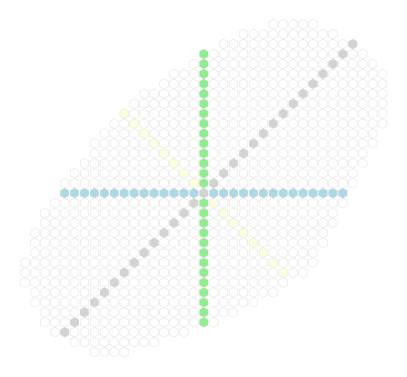

In [14]:
## Actual plotting
# Grid
fig, ax, hexagons = plot_hex_grid(original_p, original_q, hex_size=0.5, spacing=1.0, fig_size=(5, 5), labels=labels, label_type=None, text_size=6)
# Coloring the reference axes
_180_0_deg_axis, _270_90_deg_axis = color_hexagons_reference_axes(df_grid,hexagons,parameters_dict,min_max_coordinates_dict,reference_axes_dict,reference_axses_ls = ['p','q','h','v'], map_type ='regular')


Rotating values to have the dorso-ventral angle aligned top to down

In [15]:
# Original points (list_1)
import math
rotation_ls = list(zip(original_p,original_q))

# Angle for clockwise 45-degree rotation (-π/4 radians)
theta = -math.pi / 4

# Rotation matrix components
cos_theta = math.cos(theta)
sin_theta = math.sin(theta)

# Function to apply rotation to a point (x, y)
def rotate_point(x, y, cos_theta, sin_theta):
    x_new = x * cos_theta + y * sin_theta
    y_new = -x * sin_theta + y * cos_theta
    return (x_new, y_new)

# Apply rotation to each point in list_1
rotated_list = [rotate_point(x, y, cos_theta, sin_theta) for x, y in rotation_ls]


# geeting p,q coordinates back in single lists
rotated_p, rotated_q = zip(*rotated_list)
df_grid['rotated_p'] = list(rotated_p)
df_grid['rotated_q'] = list(rotated_q)

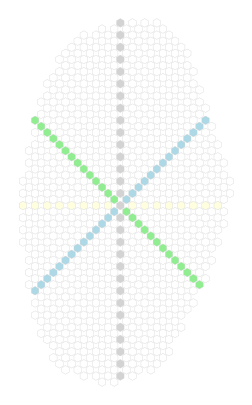

In [16]:
## Actual plotting
# Grid
fig, ax, hexagons = plot_hex_grid(df_grid['rotated_p'], df_grid['rotated_q'], hex_size=0.5, spacing=1.0, fig_size=(5, 5), labels=labels, label_type=None, text_size=6)
# Coloring the reference axes
_180_0_deg_axis, _270_90_deg_axis = color_hexagons_reference_axes(df_grid,hexagons,parameters_dict,min_max_coordinates_dict,reference_axes_dict,reference_axses_ls = ['p','q','h','v'], map_type ='regular-rotated')

### Ploting hexagonal grids

Using original q but new p coordinate values

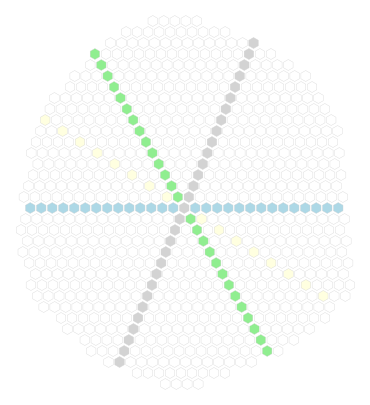

In [17]:
## Plotting on the 2D lattice: look at the reference axis (h, v, p, q)
new_p_values = df_grid['new_p'].tolist() - center_shift
fig, ax, hexagons = plot_hex_grid(new_p_values, original_q, hex_size=0.5, spacing=0.5, fig_size=(5, 5), labels=labels, label_type=None, text_size=3)
# Reference axes color
_180_0_deg_axis, _270_90_deg_axis = color_hexagons_reference_axes(df_grid, hexagons,parameters_dict,min_max_coordinates_dict,reference_axes_dict,reference_axses_ls = ['p','q','h','v'], map_type ='hexagonal')


# 4. Plotting optic flow data on the grid/lattice

The logic is to obtain:
1) the home column based on column_id assignment, 
2) the column_id of the highly connected intracolumnar input cells via absolute synaptic counts
3) draw vectors to/from home column from/to those input-cell columns

In [18]:
## Be aware that these two initial data frames do not have the same unique IDs
## Ideally they should. Think of replacing the one that has less

print(f'"ol_connections" df length: {len(ol_connections.to_cell_id.unique())}')
print(f'"columns_id_data" df length: {len(columns_id_data.root_id.unique())}')

"ol_connections" df length: 22824
"columns_id_data" df length: 23452


In [46]:
## Ploting setting

color_dict = {'T4a':'g','T4b':'b', 'T4c':'r', 'T4d':'y'}
correlator = 'HR-BL' # 'BL' for Barlow-Levick, 'HR' for Hassenstein-Reichert, 'HR-BL' for the combination
to_cell_of_interest = 'T4a'
_map_type = 'regular' # 'hexagonal', 'regular', 'regular-rotated'
filtering_for_3_column_model = False # Considering all T4 irrespective of inputs being (True) or not (False) in different consecutive columns

In [47]:
## Getting inputs of the cell of interest implementing the BL correlator
BL_cell_of_interest = 'Mi4'

cell_of_interest_inputs = ol_connections_extended[(ol_connections_extended.to_cell_type == to_cell_of_interest) & (ol_connections_extended.from_cell_type == BL_cell_of_interest)].copy()
num_of_cells = len(cell_of_interest_inputs[cell_of_interest_inputs.to_cell_type == to_cell_of_interest].to_cell_id.unique())
num_of_columns = len(cell_of_interest_inputs[cell_of_interest_inputs.to_cell_type == to_cell_of_interest].to_column_id.unique())
print(f'Number of unique postsynaptic cells / columns of interest: {num_of_cells} / {num_of_columns}')

# Sort by to_cell_id and synapses in descending order
cell_of_interest_inputs_sorted = cell_of_interest_inputs.sort_values(by=['to_cell_id', 'synapses'], ascending=[True, False])

# Group by to_cell_id and take the first row for each group (highest synapse value)
BL_unique_highest_inputs = cell_of_interest_inputs_sorted.drop_duplicates(subset='to_cell_id', keep='first').copy()

#Dropping 'not assigned' rows
BL_unique_highest_inputs_filtered = BL_unique_highest_inputs[BL_unique_highest_inputs.to_column_id != 'not assigned'].copy()

# Find the duplicates with the same to_cell_id and synapse value
BL_duplicates_in_highest_inputs = cell_of_interest_inputs_sorted[cell_of_interest_inputs_sorted.duplicated(subset=['to_cell_id', 'synapses'], keep=False)]

# Changing column names for clarity
BL_unique_highest_inputs_filtered.rename(columns={'from_cell_id': 'BL_cell_id', 'from_cell_type': 'BL_cell_type', 'from_column_id': 'BL_column_id', 
                                                  'to_cell_id': 'home_cell_id', 'to_cell_type': 'home_cell_type','to_column_id': 'home_column_id','synapses' :'BL_synapses'},inplace = True)
# Comvertions to strings
BL_unique_highest_inputs_filtered['BL_cell_id'] = BL_unique_highest_inputs_filtered['BL_cell_id'].apply(str)


# Display the resulting data frames
print("\nUnique Highest Inputs:")
display(BL_unique_highest_inputs_filtered.head())
print(f'\n"BL_unique_highest_inputs" df length: {len(BL_unique_highest_inputs_filtered)}')

Number of unique postsynaptic cells / columns of interest: 664 / 655

Unique Highest Inputs:


,BL_cell_id,home_cell_id,BL_synapses,BL_cell_type,BL_column_id,home_cell_type,home_column_id
252139,720575940640153405,720575940599755718,9,Mi4,634,T4a,741
172554,720575940628459281,720575940600101641,5,Mi4,372,T4a,487
215376,720575940632805919,720575940600143369,7,Mi4,529,T4a,662
167847,720575940628015379,720575940600547529,2,Mi4,215,T4a,727
131632,720575940624711658,720575940603491957,4,Mi4,49,T4a,391



"BL_unique_highest_inputs" df length: 654


In [48]:
## Getting inputs of the cell of interest implementing the HR correlator
HR_cell_of_interest = 'Mi9'

cell_of_interest_inputs = ol_connections_extended[(ol_connections_extended.to_cell_type == to_cell_of_interest) & (ol_connections_extended.from_cell_type == HR_cell_of_interest)].copy()
num_of_cells = len(cell_of_interest_inputs[cell_of_interest_inputs.to_cell_type == to_cell_of_interest].to_cell_id.unique())
num_of_columns = len(cell_of_interest_inputs[cell_of_interest_inputs.to_cell_type == to_cell_of_interest].to_column_id.unique())
print(f'Number of unique postsynaptic cells / columns of interest: {num_of_cells} / {num_of_columns}')

# Sort by to_cell_id and synapses in descending order
cell_of_interest_inputs_sorted = cell_of_interest_inputs.sort_values(by=['to_cell_id', 'synapses'], ascending=[True, False])

# Group by to_cell_id and take the first row for each group (highest synapse value)
HR_unique_highest_inputs = cell_of_interest_inputs_sorted.drop_duplicates(subset='to_cell_id', keep='first')

#Dropping 'not assigned' rows
HR_unique_highest_inputs_filtered = HR_unique_highest_inputs[HR_unique_highest_inputs.to_column_id != 'not assigned'].copy()

# Find the duplicates with the same to_cell_id and synapse value
HR_duplicates_in_highest_inputs = cell_of_interest_inputs_sorted[cell_of_interest_inputs_sorted.duplicated(subset=['to_cell_id', 'synapses'], keep=False)]

# Changing column names for clarity
HR_unique_highest_inputs_filtered.rename(columns={'from_cell_id': 'HR_cell_id', 'from_cell_type': 'HR_cell_type', 'from_column_id': 'HR_column_id', 
                                                  'to_cell_id': 'home_cell_id', 'to_cell_type': 'home_cell_type','to_column_id': 'home_column_id','synapses' :'HR_synapses'}, inplace = True)
# Comvertions to strings
HR_unique_highest_inputs_filtered['HR_cell_id'] = HR_unique_highest_inputs_filtered['HR_cell_id'].apply(str)


# Display the resulting data frames
print("\nUnique Highest Inputs:")
display(HR_unique_highest_inputs_filtered.head())
print(f'\n"HR_unique_highest_inputs" df length: {len(HR_unique_highest_inputs_filtered)}')

#print("\nDuplicates in Highest Inputs:")
#print(HR_duplicates_in_highest_inputs.head())
#print(len(HR_duplicates_in_highest_inputs))

Number of unique postsynaptic cells / columns of interest: 692 / 682

Unique Highest Inputs:


,HR_cell_id,home_cell_id,HR_synapses,HR_cell_type,HR_column_id,home_cell_type,home_column_id
73328,720575940619122036,720575940599755718,4,Mi9,634,T4a,741
65276,720575940618080285,720575940600101641,18,Mi9,529,T4a,487
118611,720575940623522857,720575940600143369,9,Mi9,465,T4a,662
259842,720575940643823924,720575940600547529,5,Mi9,488,T4a,727
122720,720575940623898760,720575940603491957,14,Mi9,316,T4a,391



"HR_unique_highest_inputs" df length: 681


In [49]:
## Combining the two correlators

# Merge data frames of both correlators (with inner join to keep only the rows with keys that are present in both DataFrames)
HR_BL_unique_highest_inputs_filtered = BL_unique_highest_inputs_filtered.merge(
    HR_unique_highest_inputs_filtered[['HR_cell_id', 'HR_cell_type','HR_synapses','HR_column_id','home_cell_id']],
    how='inner',
    left_on='home_cell_id',
    right_on='home_cell_id'
)

#Dropping 'not assigned' rows
HR_BL_unique_highest_inputs_filtered = HR_BL_unique_highest_inputs_filtered[HR_BL_unique_highest_inputs_filtered.BL_column_id != 'not assigned'].copy()
HR_BL_unique_highest_inputs_filtered = HR_BL_unique_highest_inputs_filtered[HR_BL_unique_highest_inputs_filtered.HR_column_id != 'not assigned'].copy()

# Display the resulting data frames
print("\nUnique Highest Inputs:")
display(HR_BL_unique_highest_inputs_filtered.head())
print(f'\n"HR_BL_unique_highest_inputs_filtered" df length: {len(HR_BL_unique_highest_inputs_filtered)}')


Unique Highest Inputs:


,BL_cell_id,home_cell_id,BL_synapses,BL_cell_type,BL_column_id,home_cell_type,home_column_id,HR_cell_id,HR_cell_type,HR_synapses,HR_column_id
0,720575940640153405,720575940599755718,9,Mi4,634,T4a,741,720575940619122036,Mi9,4,634
1,720575940628459281,720575940600101641,5,Mi4,372,T4a,487,720575940618080285,Mi9,18,529
2,720575940632805919,720575940600143369,7,Mi4,529,T4a,662,720575940623522857,Mi9,9,465
3,720575940628015379,720575940600547529,2,Mi4,215,T4a,727,720575940643823924,Mi9,5,488
4,720575940624711658,720575940603491957,4,Mi4,49,T4a,391,720575940623898760,Mi9,14,316



"HR_BL_unique_highest_inputs_filtered" df length: 620


In [50]:
test = HR_BL_unique_highest_inputs_filtered[HR_BL_unique_highest_inputs_filtered.BL_synapses == HR_BL_unique_highest_inputs_filtered.HR_synapses].copy()
test[test['HR_column_id'] != test['BL_column_id']]

,BL_cell_id,home_cell_id,BL_synapses,BL_cell_type,BL_column_id,home_cell_type,home_column_id,HR_cell_id,HR_cell_type,HR_synapses,HR_column_id
15,720575940627358474,720575940605055660,4,Mi4,395,T4a,333,720575940622353065,Mi9,4,697
20,720575940638136902,720575940606181762,4,Mi4,190,T4a,6,720575940620759322,Mi9,4,40
29,720575940624170189,720575940607814665,6,Mi4,486,T4a,501,720575940630382188,Mi9,6,705
37,720575940638244068,720575940608498955,5,Mi4,172,T4a,440,720575940618071953,Mi9,5,353
57,720575940615710406,720575940611108194,4,Mi4,708,T4a,612,720575940617251723,Mi9,4,354
...,...,...,...,...,...,...,...,...,...,...,...
593,720575940628006056,720575940641657396,4,Mi4,79,T4a,534,720575940624215221,Mi9,4,118
594,720575940619893887,720575940642820388,4,Mi4,122,T4a,509,720575940629420618,Mi9,4,555
598,720575940645983511,720575940643758280,3,Mi4,386,T4a,386,720575940625994756,Mi9,3,622
614,720575940627344996,720575940654955937,4,Mi4,401,T4a,617,720575940610277188,Mi9,4,606


In [51]:
if filtering_for_3_column_model:
    ## Filterin out T4s (rows in the data frame) in which Mi4 and Mi9 main inputs are coming from the same columns
    HR_BL_unique_highest_inputs_filtered = HR_BL_unique_highest_inputs_filtered[HR_BL_unique_highest_inputs_filtered['HR_column_id'] != HR_BL_unique_highest_inputs_filtered['BL_column_id']].copy()
    ## Filterin out T4s (rows in the data frame) in which Mi4 and Mi1 main inputs are coming from the same columns
    HR_BL_unique_highest_inputs_filtered = HR_BL_unique_highest_inputs_filtered[HR_BL_unique_highest_inputs_filtered['home_column_id'] != HR_BL_unique_highest_inputs_filtered['BL_column_id']].copy()
    ## Filterin out T4s (rows in the data frame) in which Mi9 and Mi1 main inputs are coming from the same columns
    HR_BL_unique_highest_inputs_filtered = HR_BL_unique_highest_inputs_filtered[HR_BL_unique_highest_inputs_filtered['home_column_id'] != HR_BL_unique_highest_inputs_filtered['HR_column_id']].copy()
    display(HR_BL_unique_highest_inputs_filtered)

else:
    print('Considering all T4 irrespective of inputs being or not in different consecutive columns')


,BL_cell_id,home_cell_id,BL_synapses,BL_cell_type,BL_column_id,home_cell_type,home_column_id,HR_cell_id,HR_cell_type,HR_synapses,HR_column_id
1,720575940628459281,720575940600101641,5,Mi4,372,T4a,487,720575940618080285,Mi9,18,529
2,720575940632805919,720575940600143369,7,Mi4,529,T4a,662,720575940623522857,Mi9,9,465
3,720575940628015379,720575940600547529,2,Mi4,215,T4a,727,720575940643823924,Mi9,5,488
4,720575940624711658,720575940603491957,4,Mi4,49,T4a,391,720575940623898760,Mi9,14,316
5,720575940623327495,720575940603526005,10,Mi4,328,T4a,682,720575940620263640,Mi9,15,698
...,...,...,...,...,...,...,...,...,...,...,...
615,720575940627842280,720575940655109793,2,Mi4,543,T4a,29,720575940637651312,Mi9,11,701
617,720575940638261311,720575940660454017,3,Mi4,394,T4a,615,720575940637578893,Mi9,11,568
618,720575940623692179,720575940660772993,2,Mi4,623,T4a,523,720575940635082091,Mi9,6,66
619,720575940616382014,720575940660868481,3,Mi4,748,T4a,639,720575940629819547,Mi9,7,378


## 4.1. Vectors on grid

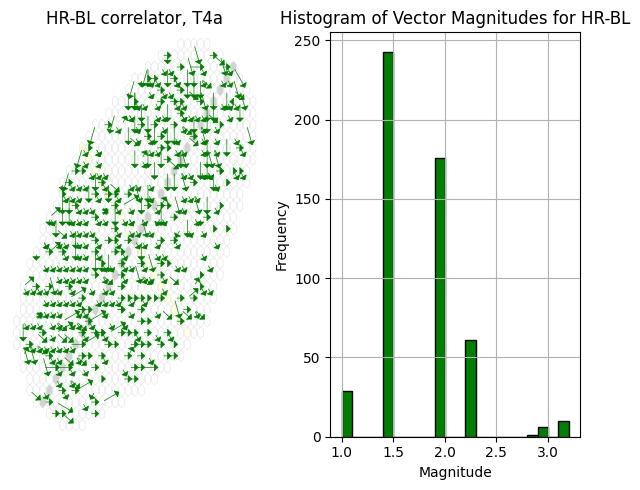

Unique magnitudes in the histogram: [1.         1.41421356 2.         2.23606798 2.82842712 3.
 3.16227766]

Possible ditances between columns in a regular grid:
0, 1, Sqrt(2): 1.4142135623730951,2, Sqrt(5): 2.23606797749979,Sqrt(8): 2.8284271247461903, 3, Sqrt(10): 3.1622776601683795

Possible ditances between columns in a hexagonal grid:
0, 1, Sqrt(sqrt(2)+1): 1.5537739740300374,2, 3


In [52]:
import matplotlib.pyplot as plt
import numpy as np

if _map_type == 'hexagonal':
    original_p = pd.Series(df_grid['new_p'] - center_shift)
    original_q = df_grid['q']
elif _map_type == 'regular-rotated':
    original_p = df_grid['rotated_p']
    original_q = df_grid['rotated_q']

# Create a figure with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 5))  # Adjust figure size as needed

## Plot 1: Hexagonal grid
fig, ax1, hexagons = plot_hex_grid(original_p, original_q, hex_size=0.5, spacing=0.5, fig_size=(5, 5), labels=labels, label_type=None, text_size=3, ax=ax1)

# Reference axes color
_180_0_deg_axis, _270_90_deg_axis = color_hexagons_reference_axes(df_grid, hexagons, parameters_dict, min_max_coordinates_dict, reference_axes_dict, reference_axses_ls=['h', 'v'], map_type=_map_type)

# Adding start and end coordinates and ids for all correlators (step before drawing)
corr_ls = ['BL', 'HR', 'HR-BL']
getting_correlators_start_end_coordinates(corr_ls, df_grid, HR_BL_unique_highest_inputs_filtered, map_type=_map_type)

# Draw vector from hexagon to hexagon
draw_correlator_vectors(correlator, HR_BL_unique_highest_inputs_filtered, ax1, color_dict, to_cell_of_interest)

ax1.set_title(f'{correlator} correlator, {to_cell_of_interest}')

## Plot 2: Histogram of vector magnitudes
start_coords = np.array(HR_BL_unique_highest_inputs_filtered[f'{correlator}_start_coords'])
end_coords = np.array(HR_BL_unique_highest_inputs_filtered[f'{correlator}_end_coords'])

# Convert the list of tuples into a 2D array for easier manipulation
start_coords = np.array([list(coord) for coord in start_coords])
end_coords = np.array([list(coord) for coord in end_coords])

magnitudes = np.sqrt((end_coords[:, 0] - start_coords[:, 0])**2 + 
                     (end_coords[:, 1] - start_coords[:, 1])**2)
# Round the values to 8 decimal places to eliminate tiny floating-point differences
magnitudes = np.round(magnitudes, decimals=8)

# Save the magnitudes in the dictionary or DataFrame
HR_BL_unique_highest_inputs_filtered[f'{correlator}_magnitude'] = magnitudes

# Plot the histogram of magnitudes on the second axis (ax2)
# Adjusting the bin width for 0.1. Important for getting the real distribution of all possible distances in the regular grid
bin_width = np.arange(min(magnitudes), max(magnitudes) + 0.1, 0.1)  
ax2.hist(magnitudes, bins=bin_width, color=color_dict[to_cell_of_interest], edgecolor='black')

ax2.set_title(f'Histogram of Vector Magnitudes for {correlator}')
ax2.set_xlabel('Magnitude')
ax2.set_ylabel('Frequency')
ax2.grid(True)

# Adjust layout to avoid overlap
plt.tight_layout()

# Display the combined figure
plt.show()
print(f'Unique magnitudes in the histogram: {np.unique(magnitudes)}')
print('\nPossible ditances between columns in a regular grid:')
print(f'0, 1, Sqrt(2): {np.sqrt(2)},2, Sqrt(5): {np.sqrt(5)},Sqrt(8): {np.sqrt(8)}, 3, Sqrt(10): {np.sqrt(10)}') 

print('\nPossible ditances between columns in a hexagonal grid:')
print(f'0, 1, Sqrt(sqrt(2)+1): {np.sqrt(np.sqrt(2)+1)},2, 3') 



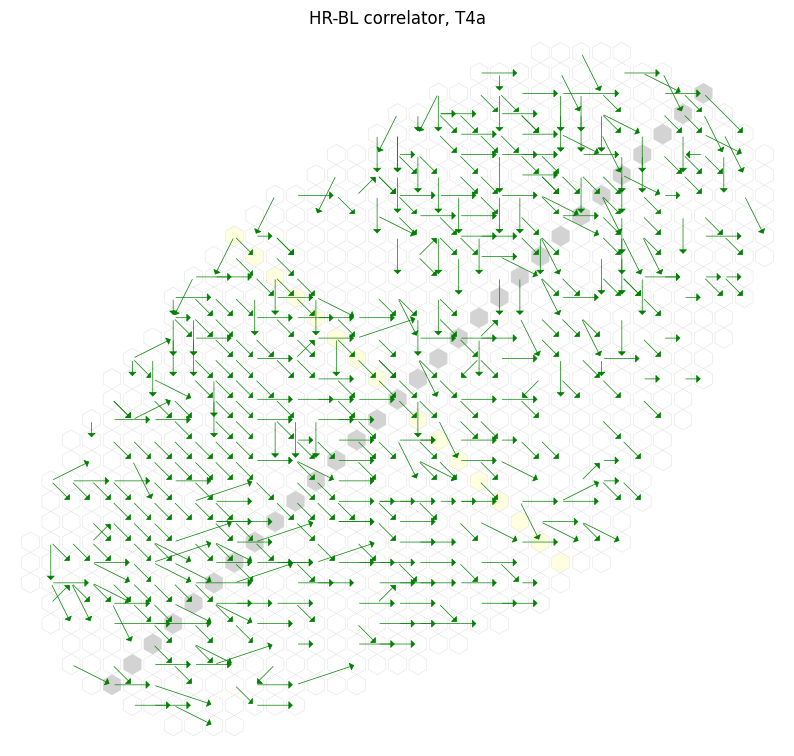

In [53]:
if _map_type == 'hexagonal':
    print('Plotting heagonal map')
    original_p = pd.Series(df_grid['new_p'] - center_shift)
    original_q = df_grid['q']
elif  _map_type == 'regular':
    original_p = df_grid['p']
    original_q = df_grid['q']
elif _map_type == 'regular-rotated':
    original_p = df_grid['rotated_p']
    original_q = df_grid['rotated_q']
    
fig, ax, hexagons = plot_hex_grid(original_p, original_q, hex_size=0.5, spacing=0.5, fig_size=(10, 10), labels=labels, label_type=None, text_size=3)
# Reference axes color
_180_0_deg_axis, _270_90_deg_axis = color_hexagons_reference_axes(df_grid, hexagons,parameters_dict,min_max_coordinates_dict,reference_axes_dict,reference_axses_ls = ['h','v'], map_type =_map_type)

# Adding start and end coordinates and ids for all correlators (step before drawung)
corr_ls = ['BL', 'HR', 'HR-BL']
getting_correlators_start_end_coordinates(corr_ls, df_grid, HR_BL_unique_highest_inputs_filtered, map_type = _map_type)

# Draw vector from hexagon to hexagon
draw_correlator_vectors(correlator, HR_BL_unique_highest_inputs_filtered, ax, color_dict, to_cell_of_interest)

plt.title(f'{correlator} correlator, {to_cell_of_interest}')
plt.show()

In [54]:
## Checking column-to-column distance
from sklearn.neighbors import NearestNeighbors

# Assuming original_p and original_q are pandas Series containing x and y values
x_values = original_p.to_numpy()  # Convert pandas series to NumPy array
y_values = original_q.to_numpy()

# Combine x and y into a 2D array of points
points = np.column_stack((x_values, y_values))

# Use NearestNeighbors from scikit-learn to find the nearest neighbors
nbrs = NearestNeighbors(n_neighbors=2, algorithm='auto').fit(points)

# Find the distances to the nearest neighbor (excluding the point itself)
distances, indices = nbrs.kneighbors(points)

# The first column will be the point itself (distance = 0), so we take the second column
min_distances = distances[:, 1]
min_distances = np.round(min_distances, decimals=8) 
print(f'The column-to-column distance is: {np.unique(min_distances)}')



The column-to-column distance is: [1.]


In [55]:
# Calculating the angles for all the vectors relative to the eye´s equator
points = _180_0_deg_axis
getting_correlators_angles(points, HR_BL_unique_highest_inputs_filtered, corr_ls)

,BL_cell_id,home_cell_id,BL_synapses,BL_cell_type,BL_column_id,home_cell_type,home_column_id,HR_cell_id,HR_cell_type,HR_synapses,...,HR_start_coords,HR_end_coords,HR-BL_start_ids,HR-BL_end_ids,HR-BL_start_coords,HR-BL_end_coords,HR-BL_magnitude,BL_angle,HR_angle,HR-BL_angle
1,720575940628459281,720575940600101641,5,Mi4,372,T4a,487,720575940618080285,Mi9,18,...,"(-3, 1)","(-2, 1)",529,372,"(-3, 1)","(-2, 0)",1.414214,315,45,0
2,720575940632805919,720575940600143369,7,Mi4,529,T4a,662,720575940623522857,Mi9,9,...,"(-3, 3)","(-3, 2)",465,529,"(-3, 3)","(-3, 1)",2.000000,315,315,315
3,720575940628015379,720575940600547529,2,Mi4,215,T4a,727,720575940643823924,Mi9,5,...,"(-5, 10)","(-4, 10)",488,215,"(-5, 10)","(-3, 10)",2.000000,45,45,45
4,720575940624711658,720575940603491957,4,Mi4,49,T4a,391,720575940623898760,Mi9,14,...,"(-7, 3)","(-6, 3)",316,49,"(-7, 3)","(-6, 2)",1.414214,315,45,0
5,720575940623327495,720575940603526005,10,Mi4,328,T4a,682,720575940620263640,Mi9,15,...,"(-10, 3)","(-10, 2)",698,328,"(-10, 3)","(-10, 1)",2.000000,315,315,315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
615,720575940627842280,720575940655109793,2,Mi4,543,T4a,29,720575940637651312,Mi9,11,...,"(-2, -2)","(-1, -2)",701,543,"(-2, -2)","(-1, -3)",1.414214,315,45,0
617,720575940638261311,720575940660454017,3,Mi4,394,T4a,615,720575940637578893,Mi9,11,...,"(2, -10)","(3, -10)",568,394,"(2, -10)","(3, -11)",1.414214,315,45,0
618,720575940623692179,720575940660772993,2,Mi4,623,T4a,523,720575940635082091,Mi9,6,...,"(5, 10)","(5, 9)",66,623,"(5, 10)","(5, 8)",2.000000,315,315,315
619,720575940616382014,720575940660868481,3,Mi4,748,T4a,639,720575940629819547,Mi9,7,...,"(12, 6)","(13, 6)",378,748,"(12, 6)","(14, 6)",2.000000,45,45,45


### Adding synaptic weight to PD vectors and weighting the HR-BL correlator

The main idea here is to add to each vector an absolute synapse value or a normalized (relative) weight as the length of the vectors. Then, analyze and plot the vector average. 

In [56]:
# Calculating input fractions and normalizing to the may for all correlators
get_input_fractions_and_norm(ol_connections, HR_BL_unique_highest_inputs_filtered)

In [57]:
# Calculating a weighted HR-BL correlator
avg_resultant_radius, avg_resultant_angle = get_weighted_correlator(HR_BL_unique_highest_inputs_filtered)

### Plotting

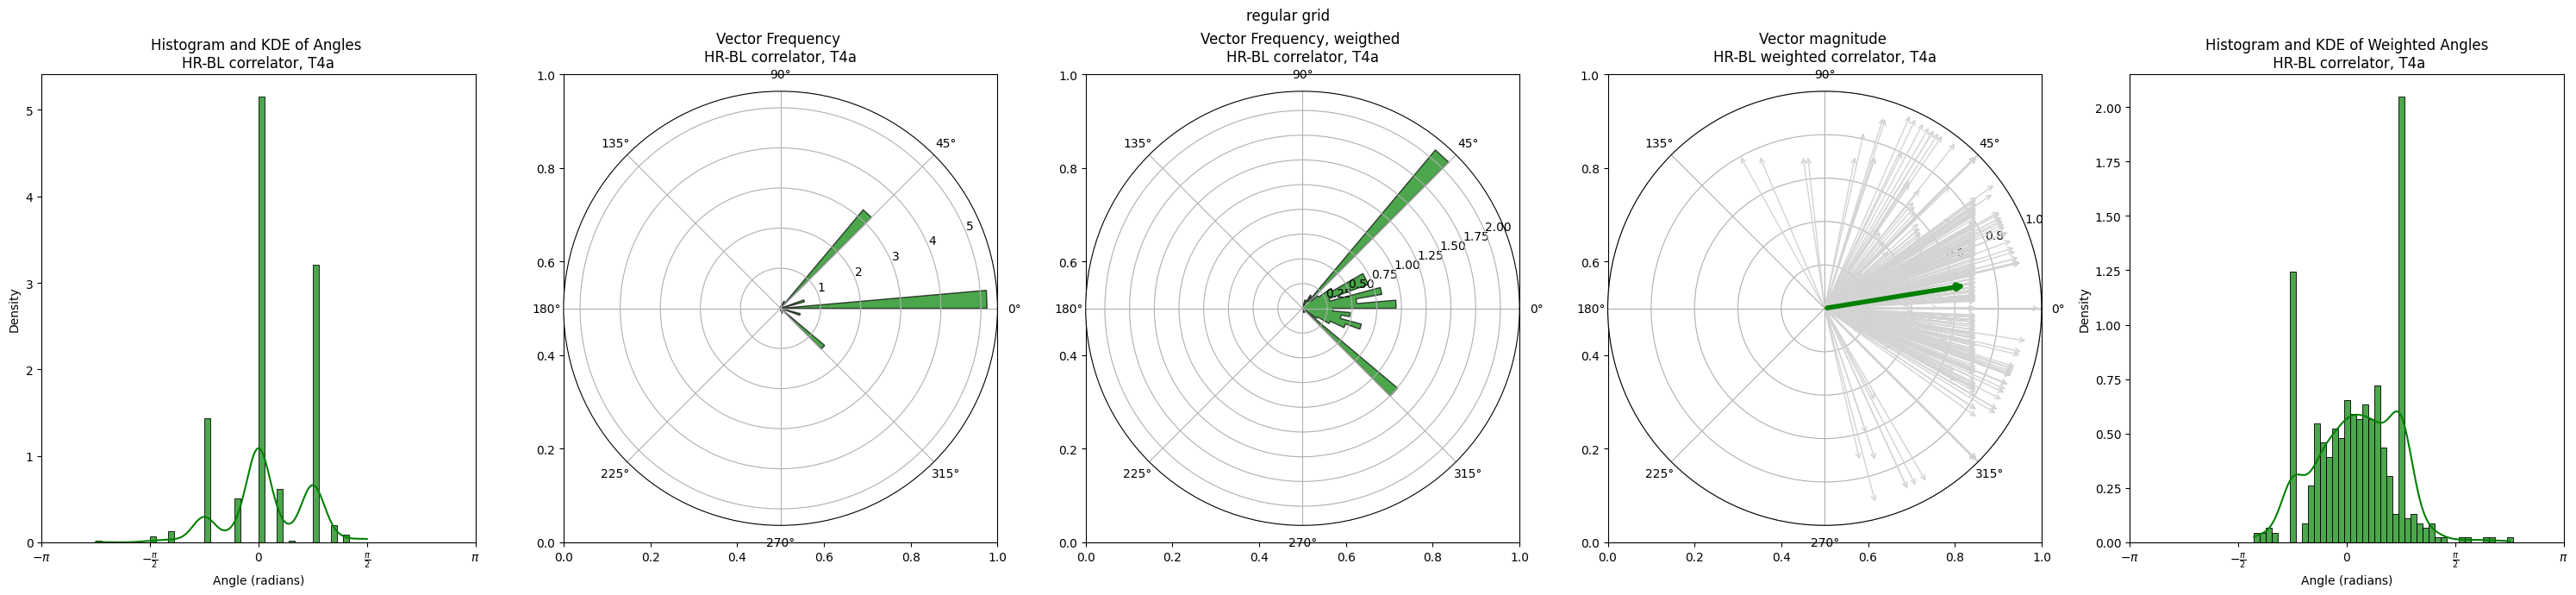

In [58]:
# Extracting angles and defining vector length
angles = HR_BL_unique_highest_inputs_filtered[f'{correlator}_angle']  # assuming angles are in degrees
angles_rad = np.radians(angles)  # Convert angles to radians
vector_length = f'max_norm_{correlator}_synapses'  # Choose the variable you wanna plot in subplot 3
weighted_angles = HR_BL_unique_highest_inputs_filtered['HR-BL_weighted_vector_angle']  # assuming angles are in degrees
weighted_angles_rad = np.radians(weighted_angles)  # Convert angles to radians



# Angle normalization
if to_cell_of_interest == 'T4b': # Normalize angles to range 0 to 2π
    angles_rad = np.mod(angles_rad, 2 * np.pi) 
    weighted_angles_rad = np.mod(weighted_angles_rad, 2 * np.pi) 
else:
    angles_rad = np.mod(angles_rad + np.pi, 2 * np.pi) - np.pi # Normalize angles to the range -π to π
    weighted_angles_rad = np.mod(weighted_angles_rad + np.pi, 2 * np.pi) - np.pi # Normalize angles to the range -π to π



# Plotting
fig, axs = plt.subplots(1, 5, figsize=(30, 7))  # Adjust the figsize for the extra subplot

# Histogram + KDE Plot for angles_rad
bin_width_5_deg = np.arange(min(angles_rad), max(angles_rad) + np.deg2rad(5), np.deg2rad(5)) # adusting the binwidth for 5 degrees
sns.histplot(angles_rad, ax=axs[0], kde=True, color=color_dict[to_cell_of_interest], bins=bin_width_5_deg, stat="density", edgecolor='black', alpha=0.7)
axs[0].set_title(f'Histogram and KDE of Angles \n{correlator} correlator, {to_cell_of_interest}')
axs[0].set_xlabel('Angle (radians)')
axs[0].set_ylabel('Density')

# Set custom ticks and labels
ticks = [-np.pi, -np.pi/2, 0, np.pi/2, np.pi]
tick_labels = [r'$-\pi$', r'$-\frac{\pi}{2}$', r'$0$', r'$\frac{\pi}{2}$', r'$\pi$']

# For layer B
if to_cell_of_interest == 'T4b':
    ticks = [0, np.pi/2, np.pi, 1.5*np.pi, 2*np.pi]
    tick_labels = [r'$0$', r'$0.5\pi$', r'$\pi$', r'$1.5\pi$', r'$2\pi$']

    
axs[0].set_xticks(ticks)
axs[0].set_xticklabels(tick_labels)

# Polar Plot (HR-BL weighted sum)
axs[1] = plt.subplot(152, projection='polar')
axs[1].set_title(f'Vector Frequency \n{correlator} correlator, {to_cell_of_interest}')

# Plot the histogram
hist, bin_edges = np.histogram(angles_rad, bins=bin_width_5_deg, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
axs[1].hist(angles_rad, bins=bin_width_5_deg, density=True, edgecolor='black', color=color_dict[to_cell_of_interest], alpha=0.7, histtype='stepfilled')

# Calculate the KDE
kde = gaussian_kde(angles_rad, bw_method='scott')  # Adjust the bandwidth method if needed
theta = np.linspace(-np.pi, np.pi, 1000)  # Cover the range from -pi to pi
kde_values = kde(theta) * 5  # This extra number (e.g., +5) has been manually added to adjust the fit

# Plot the KDE on the polar plot
#axs[1].plot(theta, kde_values, color=color_dict[to_cell_of_interest], lw=2) # Commented out, you can include this optionally


# Plot the histogram - weighted vectors
axs[2] = plt.subplot(153, projection='polar')
axs[2].set_title(f'Vector Frequency, weigthed \n{correlator} correlator, {to_cell_of_interest}')
hist, bin_edges = np.histogram(weighted_angles_rad, bins=bin_width_5_deg, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
axs[2].hist(weighted_angles_rad, bins=bin_width_5_deg, density=True, edgecolor='black', color=color_dict[to_cell_of_interest], alpha=0.7, histtype='stepfilled')



# Polar Plot (Histogram + KDE)
#axs[2] = plt.subplot(153, projection='polar')
#axs[2].set_title(f'Vector magnitude \n{correlator} correlator, {to_cell_of_interest}')

# Initialize lists to store the cartesian coordinates
#x_components = []
#y_components = []
#angles_rad = []
#radii = []

#for _, row in HR_BL_unique_highest_inputs_filtered.iterrows():
    ## Convert angle from degrees to radians
    #angle_rad = np.deg2rad(row[f'{correlator}_angle'])
    #radius = row[vector_length]

    ## Store angles and radii for averaging
    #angles_rad.append(angle_rad)
    #radii.append(radius)

    ## Apply noise to the angle
    #noise = np.deg2rad(np.random.normal(loc=0, scale=10))
    #perturbed_angle = angle_rad + noise
    #perturbed_angle = angle_rad
    
    ## Plot the vector using annotate to create an arrow
    #axs[2].annotate("", xy=(perturbed_angle, radius), xytext=(0, 0),
                #arrowprops=dict(arrowstyle="->", color='lightgray', lw=1.5))
    
    ## Store the cartesian coordinates
    #x_components.append(radius * np.cos(angle_rad))
    #y_components.append(radius * np.sin(angle_rad))

## Calculate the average x and y components
#avg_x = np.mean(x_components)
#avg_y = np.mean(y_components)

## Convert the average x and y components back to polar coordinates
#avg_radius = np.sqrt(avg_x**2 + avg_y**2)
#avg_angle = np.arctan2(avg_y, avg_x)

## Plot the average vector as a blue arrow
#axs[2].annotate("", xy=(avg_angle, avg_radius), xytext=(0, 0),
            #arrowprops=dict(arrowstyle="->", color=color_dict[to_cell_of_interest], lw=4))

## Convert lists to a DataFrame to group by angle
#angle_radius_df = pd.DataFrame({
    #'angle_rad': angles_rad,
    #'radius': radii})

## Group by angle and calculate the average radius for each angle
#average_radii = angle_radius_df.groupby('angle_rad').mean().reset_index()

## Plot the average vectors as red arrows
#for _, row in average_radii.iterrows():
    #axs[2].annotate("", xy=(row['angle_rad'], row['radius']), xytext=(0, 0),
                #arrowprops=dict(arrowstyle="->", color=color_dict[to_cell_of_interest], lw=0.5))

## Plot configuration
#axs[2].set_rmin(0)
#axs[2].set_rmax(HR_BL_unique_highest_inputs_filtered[vector_length].max())



# Polar Plot (Vectors)
axs[3] = plt.subplot(154, projection='polar')
axs[3].set_title(f'Vector magnitude \nHR-BL weighted correlator, {to_cell_of_interest}')

# Loop through each row to plot the vectors
for index, row in HR_BL_unique_highest_inputs_filtered.iterrows():
    angle_rad = np.deg2rad(row['HR-BL_weighted_vector_angle'])  # Convert the angle back to radians for polar plot
    radius = row['HR-BL_weighted_vector_magnitude']
    
    axs[3].annotate("", xy=(angle_rad, radius), xytext=(0, 0),
                arrowprops=dict(arrowstyle="->", color='lightgray', lw=1))

# Plot the average vector as a blue arrow
axs[3].annotate("", xy=(avg_resultant_angle, avg_resultant_radius), xytext=(0, 0),
            arrowprops=dict(arrowstyle="->", color=color_dict[to_cell_of_interest], lw=4))

# PLot frequencies of weighed angles
weighted_angles = HR_BL_unique_highest_inputs_filtered['HR-BL_weighted_vector_angle']  # assuming angles are in degrees
weighted_angles_rad = np.radians(weighted_angles)  # Convert angles to radians

# Angle normalization
if to_cell_of_interest == 'T4b': # Normalize angles to range 0 to 2π
    weighted_angles_rad = np.mod(weighted_angles_rad, 2 * np.pi) 
else:
    weighted_angles_rad = np.mod(weighted_angles_rad + np.pi, 2 * np.pi) - np.pi # Normalize angles to the range -π to π


# Plot frequencies of weighted angles with histogram + KDE
bin_width_5_deg = np.arange(min(weighted_angles_rad), max(weighted_angles_rad) + np.deg2rad(5), np.deg2rad(5)) # adusting the binwidth for 5 degrees
sns.histplot(weighted_angles_rad, ax=axs[4], kde=True, color=color_dict[to_cell_of_interest], bins=bin_width_5_deg, stat="density", edgecolor='black', alpha=0.7)
axs[4].set_title(f'Histogram and KDE of Weighted Angles\n HR-BL correlator, {to_cell_of_interest}')
axs[4].set_xlabel('Angle (radians)')
axs[4].set_ylabel('Density')

# Set custom ticks and labels
axs[4].set_xticks(ticks)
axs[4].set_xticklabels(tick_labels)

# Show plots
plt.suptitle(f'{_map_type} grid')
plt.tight_layout()
plt.show()


### Plotting weighted vectors on the map

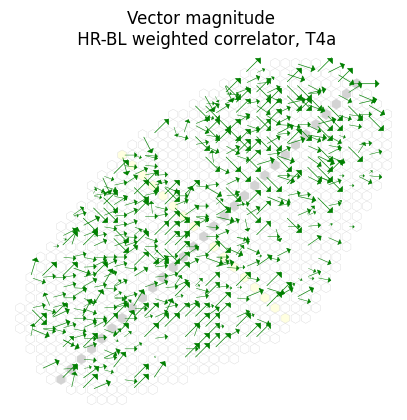

In [59]:
# Set up the figure and axes
if _map_type == 'hexagonal':
    original_p = df_grid['new_p'].tolist() - center_shift
elif _map_type == 'regular-rotated':
    original_p = df_grid['rotated_p']
    original_q = df_grid['rotated_q']
    
fig, ax, hexagons = plot_hex_grid(original_p, original_q, hex_size=0.5, spacing=0.5, fig_size=(5, 5), labels=labels, label_type=None, text_size=3)
# Reference axes color
_180_0_deg_axis, _270_90_deg_axis = color_hexagons_reference_axes(df_grid, hexagons,parameters_dict,min_max_coordinates_dict,reference_axes_dict,reference_axses_ls = ['h','v'], map_type =_map_type)

# Define the correlator you are working with (e.g., 'HR-BL')
correlator = 'HR-BL'

# Extract the start and end coordinates, and the magnitudes
start_coords_ls = HR_BL_unique_highest_inputs_filtered[f'{correlator}_start_coords']
end_coords_ls = HR_BL_unique_highest_inputs_filtered[f'{correlator}_resultant_end_coords']
magnitude_ls = HR_BL_unique_highest_inputs_filtered[f'{correlator}_weighted_vector_magnitude']

# Loop over each vector and draw it
for start_coord, end_coord, magnitude in zip(start_coords_ls, end_coords_ls, magnitude_ls):
    # Find the coordinates of the start and end points
    x_start, y_start = start_coord
    x_end, y_end = end_coord

    # Scale the head size of the arrow based on the magnitude
    head_size = 0.25 * magnitude
    arrow_style = f'-|>,head_width={head_size},head_length={head_size}'
    
    # Draw the vector as an arrow
    ax.annotate('', xy=(x_end, y_end), xytext=(x_start, y_start),
                arrowprops=dict(arrowstyle=arrow_style, linewidth=magnitude/2, color=color_dict[to_cell_of_interest], fill=True))



# Add grid, labels, and title
ax.grid(False)
#ax.set_xlabel('X-coordinate')
#ax.set_ylabel('Y-coordinate')
ax.set_title(f'Vector magnitude \n HR-BL weighted correlator, {to_cell_of_interest}')

# Remove the box (spines) around the plot
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.set_xticks([])  # Remove x-axis ticks
ax.set_yticks([])  # Remove y-axis ticks

# Show the plot
plt.show()

### Plotting weighted vectors on the map - FILTERING

In [60]:
### Filtering data based on BL-HR alignment, giving stronger DSI

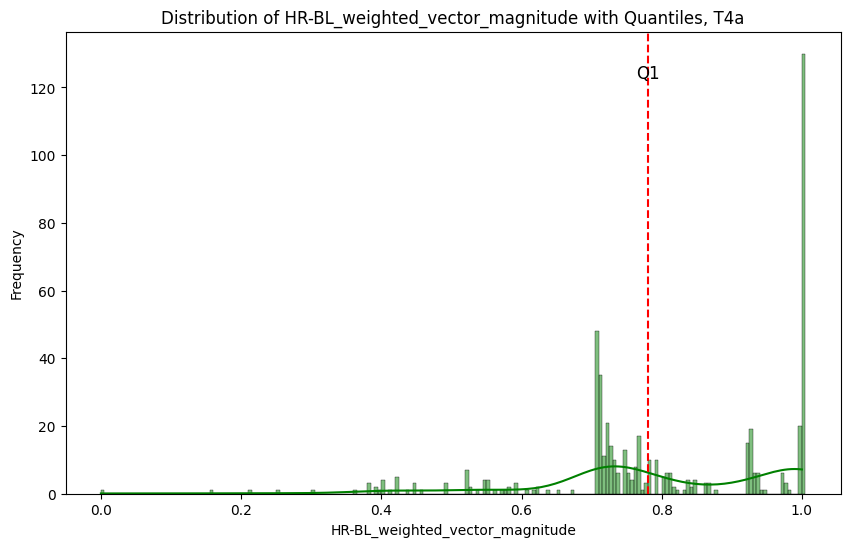

In [61]:
# Looking at the distribution and quantiles of the proxy of a DSI
data = HR_BL_unique_highest_inputs_filtered['HR-BL_weighted_vector_magnitude']

# Plotting the distribution
plt.figure(figsize=(10, 6))
bin_width = np.arange(min(data), max(data) + 0.005, 0.005)  
sns.histplot(data, kde=True, bins=bin_width, color=color_dict[to_cell_of_interest])

# Calculate the quantiles
quantiles = np.quantile(data, [0.5])

# Mark the quantiles on the plot
for i, q in enumerate(quantiles, 1):
    plt.axvline(q, color='red', linestyle='--')
    plt.text(q, plt.gca().get_ylim()[1]*0.9, f'Q{i}', color='black', ha='center', fontsize=12)

# Add titles and labels
plt.title(f'Distribution of HR-BL_weighted_vector_magnitude with Quantiles, {to_cell_of_interest}')
plt.xlabel('HR-BL_weighted_vector_magnitude')
plt.ylabel('Frequency')

# Show the plot
plt.show()


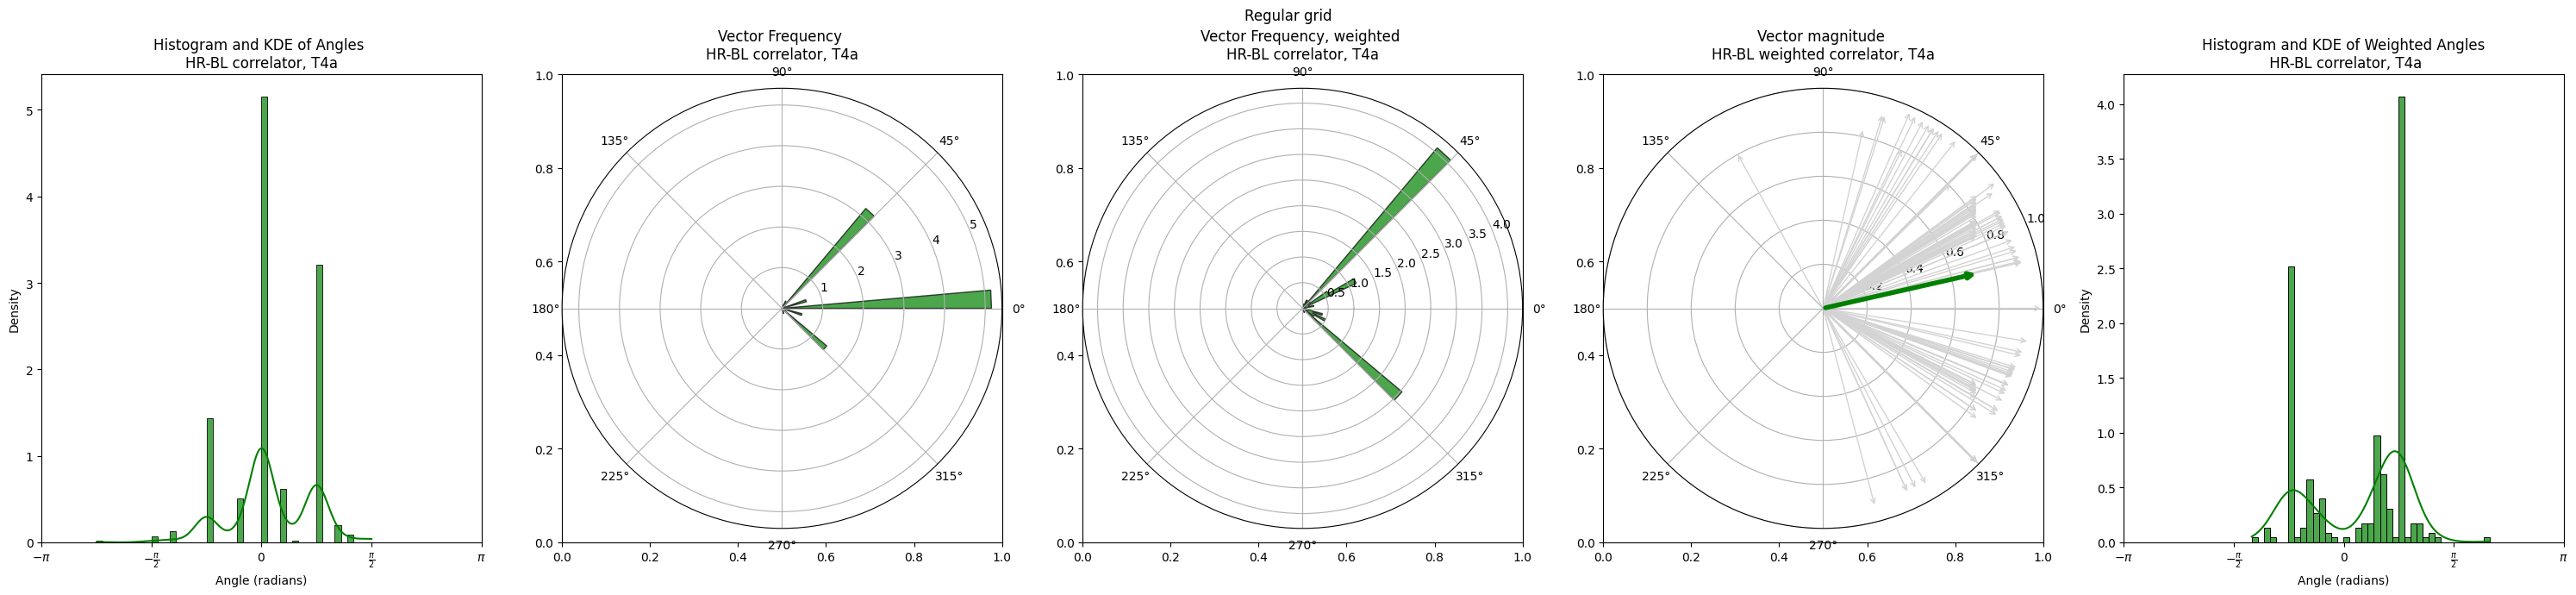

In [62]:
# Fiiltering based on BL-HR vector radius
quantile_threshold = HR_BL_unique_highest_inputs_filtered['HR-BL_weighted_vector_magnitude'].quantile(0.5)
HR_BL_unique_highest_inputs_weight_filtered = HR_BL_unique_highest_inputs_filtered[HR_BL_unique_highest_inputs_filtered['HR-BL_weighted_vector_magnitude'] > quantile_threshold ].copy()


# Selecting Data
df = HR_BL_unique_highest_inputs_weight_filtered
HR_weight_variable = 'HR_input_fraction_HR-BL' # 'HR_fraction'
BL_weight_variable = 'BL_input_fraction_HR-BL' # 'BL_fraction'

# Convert angles from degrees to radians
df['BL_angle_rad'] = np.deg2rad(df['BL_angle'])
df['HR_angle_rad'] = np.deg2rad(df['HR_angle'])

# Calculate x and y components of BL and HR vectors
df['BL_x'] = df[BL_weight_variable] * np.cos(df['BL_angle_rad'])
df['BL_y'] = df[BL_weight_variable] * np.sin(df['BL_angle_rad'])
df['HR_x'] = df[HR_weight_variable] * np.cos(df['HR_angle_rad'])
df['HR_y'] = df[HR_weight_variable] * np.sin(df['HR_angle_rad'])

# Compute resultant x and y components by summing the BL and HR components
df['resultant_x'] = df['BL_x'] + df['HR_x']
df['resultant_y'] = df['BL_y'] + df['HR_y']

# Calculate the average x and y components
avg_resultant_x = df['resultant_x'].mean()
avg_resultant_y = df['resultant_y'].mean()

# Convert the average x and y components back to polar coordinates
avg_resultant_radius = np.sqrt(avg_resultant_x**2 + avg_resultant_y**2)
avg_resultant_angle = np.arctan2(avg_resultant_y, avg_resultant_x)

# Convert resultant vector to polar form (magnitude and angle)
HR_BL_unique_highest_inputs_filtered['HR-BL_weighted_vector_magnitude'] = np.sqrt(df['resultant_x']**2 + df['resultant_y']**2)
HR_BL_unique_highest_inputs_filtered['HR-BL_weighted_vector_angle'] = np.rad2deg(np.arctan2(df['resultant_y'], df['resultant_x']))


# Extracting angles and defining vector length
angles = HR_BL_unique_highest_inputs_filtered[f'{correlator}_angle']  # assuming angles are in degrees
angles_rad = np.radians(angles)  # Convert angles to radians
vector_length = f'max_norm_{correlator}_synapses'  # Choose the variable you wanna plot in subplot 4

# Angle normalization
# Extracting angles and defining vector length
angles = HR_BL_unique_highest_inputs_filtered[f'{correlator}_angle']  # assuming angles are in degrees
angles_rad = np.radians(angles)  # Convert angles to radians
vector_length = f'max_norm_{correlator}_synapses'  # Choose the variable you wanna plot in subplot 3
weighted_angles = HR_BL_unique_highest_inputs_filtered['HR-BL_weighted_vector_angle']  # assuming angles are in degrees
weighted_angles_rad = np.radians(weighted_angles)  # Convert angles to radians



# Angle normalization
if to_cell_of_interest == 'T4b': # Normalize angles to range 0 to 2π
    angles_rad = np.mod(angles_rad, 2 * np.pi) 
    weighted_angles_rad = np.mod(weighted_angles_rad, 2 * np.pi) 
else:
    angles_rad = np.mod(angles_rad + np.pi, 2 * np.pi) - np.pi # Normalize angles to the range -π to π
    weighted_angles_rad = np.mod(weighted_angles_rad + np.pi, 2 * np.pi) - np.pi # Normalize angles to the range -π to π



# Plotting
fig, axs = plt.subplots(1, 5, figsize=(30, 7))  # Adjust the figsize for the extra subplot

# Histogram + KDE Plot for angles_rad
bin_width_5_deg = np.arange(min(angles_rad), max(angles_rad) + np.deg2rad(5), np.deg2rad(5)) # adusting the binwidth for 5 degrees
sns.histplot(angles_rad, ax=axs[0], kde=True, color=color_dict[to_cell_of_interest], bins=bin_width_5_deg, stat="density", edgecolor='black', alpha=0.7)
axs[0].set_title(f'Histogram and KDE of Angles \n{correlator} correlator, {to_cell_of_interest}')
axs[0].set_xlabel('Angle (radians)')
axs[0].set_ylabel('Density')

# Set custom ticks and labels
ticks = [-np.pi, -np.pi/2, 0, np.pi/2, np.pi]
tick_labels = [r'$-\pi$', r'$-\frac{\pi}{2}$', r'$0$', r'$\frac{\pi}{2}$', r'$\pi$']

# For layer B
if to_cell_of_interest == 'T4b':
    ticks = [0, np.pi/2, np.pi, 1.5*np.pi, 2*np.pi]
    tick_labels = [r'$0$', r'$0.5\pi$', r'$\pi$', r'$1.5\pi$', r'$2\pi$']

    
axs[0].set_xticks(ticks)
axs[0].set_xticklabels(tick_labels)

# Polar Plot (HR-BL weighted sum)
axs[1] = plt.subplot(152, projection='polar')
axs[1].set_title(f'Vector Frequency \n{correlator} correlator, {to_cell_of_interest}')

# Plot the histogram
hist, bin_edges = np.histogram(angles_rad, bins=bin_width_5_deg, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
axs[1].hist(angles_rad, bins=bin_width_5_deg, density=True, edgecolor='black', color=color_dict[to_cell_of_interest], alpha=0.7, histtype='stepfilled')

# Calculate the KDE
kde = gaussian_kde(angles_rad, bw_method='scott')  # Adjust the bandwidth method if needed
theta = np.linspace(-np.pi, np.pi, 1000)  # Cover the range from -pi to pi
kde_values = kde(theta) * 5  # This extra number (e.g., +5) has been manually added to adjust the fit

# Plot the KDE on the polar plot
#axs[1].plot(theta, kde_values, color=color_dict[to_cell_of_interest], lw=2) # Commented out, you can include this optionally


# Plot the histogram - weighted vectors
axs[2] = plt.subplot(153, projection='polar')
axs[2].set_title(f'Vector Frequency, weighted \n{correlator} correlator, {to_cell_of_interest}')
hist, bin_edges = np.histogram(weighted_angles_rad, bins=bin_width_5_deg, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
axs[2].hist(weighted_angles_rad, bins=bin_width_5_deg, density=True, edgecolor='black', color=color_dict[to_cell_of_interest], alpha=0.7, histtype='stepfilled')



# Polar Plot (Histogram + KDE)
#axs[2] = plt.subplot(153, projection='polar')
#axs[2].set_title(f'Vector magnitude \n{correlator} correlator, {to_cell_of_interest}')

# Initialize lists to store the cartesian coordinates
#x_components = []
#y_components = []
#angles_rad = []
#radii = []

#for _, row in HR_BL_unique_highest_inputs_filtered.iterrows():
    ## Convert angle from degrees to radians
    #angle_rad = np.deg2rad(row[f'{correlator}_angle'])
    #radius = row[vector_length]

    ## Store angles and radii for averaging
    #angles_rad.append(angle_rad)
    #radii.append(radius)

    ## Apply noise to the angle
    #noise = np.deg2rad(np.random.normal(loc=0, scale=10))
    #perturbed_angle = angle_rad + noise
    #perturbed_angle = angle_rad
    
    ## Plot the vector using annotate to create an arrow
    #axs[2].annotate("", xy=(perturbed_angle, radius), xytext=(0, 0),
                #arrowprops=dict(arrowstyle="->", color='lightgray', lw=1.5))
    
    ## Store the cartesian coordinates
    #x_components.append(radius * np.cos(angle_rad))
    #y_components.append(radius * np.sin(angle_rad))

## Calculate the average x and y components
#avg_x = np.mean(x_components)
#avg_y = np.mean(y_components)

## Convert the average x and y components back to polar coordinates
#avg_radius = np.sqrt(avg_x**2 + avg_y**2)
#avg_angle = np.arctan2(avg_y, avg_x)

## Plot the average vector as a blue arrow
#axs[2].annotate("", xy=(avg_angle, avg_radius), xytext=(0, 0),
            #arrowprops=dict(arrowstyle="->", color=color_dict[to_cell_of_interest], lw=4))

## Convert lists to a DataFrame to group by angle
#angle_radius_df = pd.DataFrame({
    #'angle_rad': angles_rad,
    #'radius': radii})

## Group by angle and calculate the average radius for each angle
#average_radii = angle_radius_df.groupby('angle_rad').mean().reset_index()

## Plot the average vectors as red arrows
#for _, row in average_radii.iterrows():
    #axs[2].annotate("", xy=(row['angle_rad'], row['radius']), xytext=(0, 0),
                #arrowprops=dict(arrowstyle="->", color=color_dict[to_cell_of_interest], lw=0.5))

## Plot configuration
#axs[2].set_rmin(0)
#axs[2].set_rmax(HR_BL_unique_highest_inputs_filtered[vector_length].max())

# Polar Plot (Vectors)
axs[3] = plt.subplot(154, projection='polar')
axs[3].set_title(f'Vector magnitude \nHR-BL weighted correlator, {to_cell_of_interest}')

# Loop through each row to plot the vectors
for index, row in df.iterrows():
    angle_rad = np.deg2rad(row['HR-BL_weighted_vector_angle'])  # Convert the angle back to radians for polar plot
    radius = row['HR-BL_weighted_vector_magnitude']
    
    axs[3].annotate("", xy=(angle_rad, radius), xytext=(0, 0),
                arrowprops=dict(arrowstyle="->", color='lightgray', lw=1))

# Plot the average vector
axs[3].annotate("", xy=(avg_resultant_angle, avg_resultant_radius), xytext=(0, 0),
            arrowprops=dict(arrowstyle="->", color=color_dict[to_cell_of_interest], lw=4))

# PLot frequencies of weighed angles
weighted_angles = HR_BL_unique_highest_inputs_weight_filtered['HR-BL_weighted_vector_angle']  # assuming angles are in degrees
weighted_angles_rad = np.radians(weighted_angles)  # Convert angles to radians


# Angle normalization
if to_cell_of_interest == 'T4b': # Normalize angles to range 0 to 2π
    weighted_angles_rad = np.mod(weighted_angles_rad, 2 * np.pi) 
else:
    weighted_angles_rad = np.mod(weighted_angles_rad + np.pi, 2 * np.pi) - np.pi # Normalize angles to the range -π to π


# Plot frequencies of weighted angles with histogram + KDE
bin_width_5_deg = np.arange(min(weighted_angles_rad), max(weighted_angles_rad) + np.deg2rad(5), np.deg2rad(5)) # adusting the binwidth for 5 degrees
sns.histplot(weighted_angles_rad, ax=axs[4], kde=True, color=color_dict[to_cell_of_interest], bins=bin_width_5_deg, stat="density", edgecolor='black', alpha=0.7)
axs[4].set_title(f'Histogram and KDE of Weighted Angles\n HR-BL correlator, {to_cell_of_interest}')
axs[4].set_xlabel('Angle (radians)')
axs[4].set_ylabel('Density')

# Set custom ticks and labels
axs[4].set_xticks(ticks)
axs[4].set_xticklabels(tick_labels)

# Show plots
plt.suptitle('Regular grid')
plt.tight_layout()
plt.show()

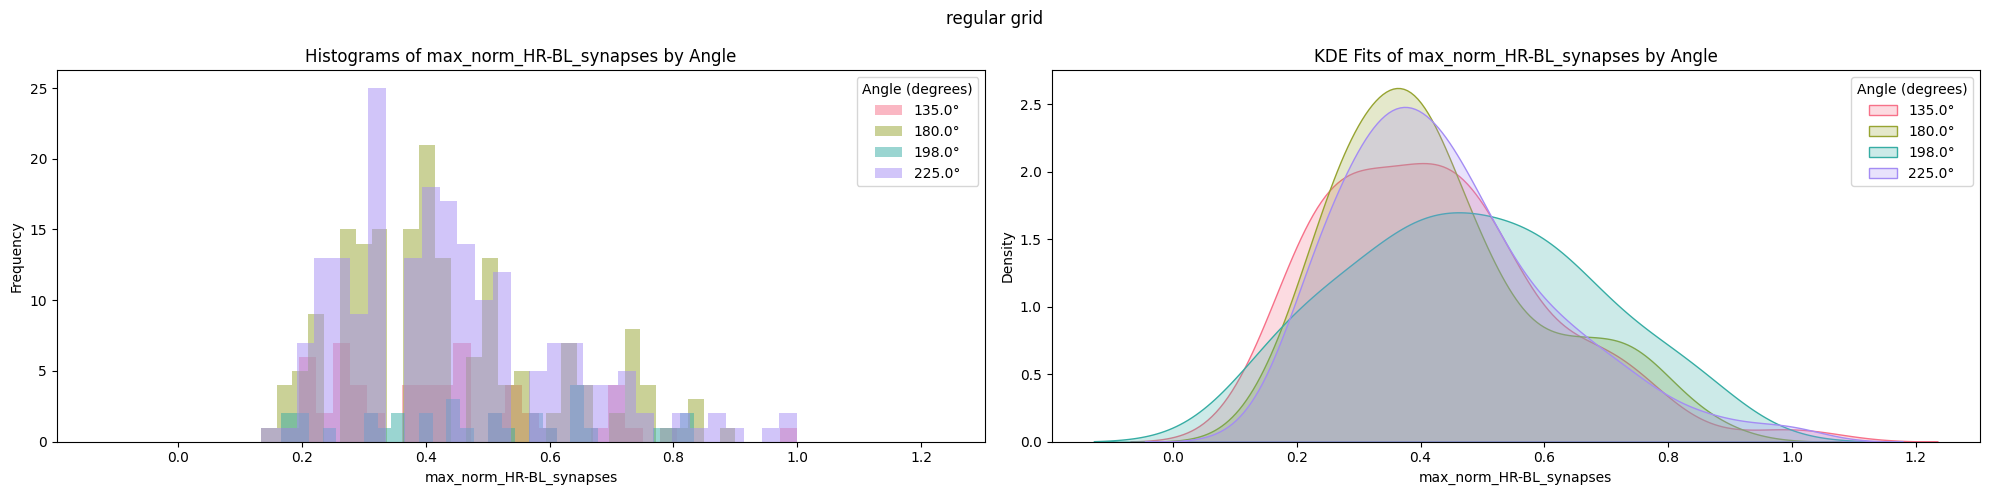

In [45]:
# Convert angle from degrees to radians and add a new column for radians
HR_BL_unique_highest_inputs_filtered['angle_rad'] = np.deg2rad(HR_BL_unique_highest_inputs_filtered[f'{correlator}_angle'])

# Group by angle and filter groups with more than five_percent_occupancy values (at least in 5% of all columns available)
five_percent_occupancy = round(len(HR_BL_unique_highest_inputs_filtered['angle_rad']) * 5 / 100)
angle_counts = HR_BL_unique_highest_inputs_filtered.groupby('angle_rad').size()
valid_angles = angle_counts[angle_counts > five_percent_occupancy].index

# Prepare the figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 5), sharex=True)

# Define a color palette
colors = sns.color_palette("husl", len(valid_angles))

# Plot histograms on the first subplot
for angle_rad, color in zip(valid_angles, colors):
    filtered_data = HR_BL_unique_highest_inputs_filtered[HR_BL_unique_highest_inputs_filtered['angle_rad'] == angle_rad]
    axes[0].hist(filtered_data[f'max_norm_{correlator}_synapses'], bins=30, color=color, alpha=0.5, label=f'{np.rad2deg(angle_rad):.1f}°')

axes[0].set_title(f'Histograms of max_norm_{correlator}_synapses by Angle')
axes[0].set_ylabel('Frequency')
axes[0].set_xlabel(f'max_norm_{correlator}_synapses')
axes[0].legend(title='Angle (degrees)')
axes[0].grid(False)

# Plot KDE fits on the second subplot
for angle_rad, color in zip(valid_angles, colors):
    filtered_data = HR_BL_unique_highest_inputs_filtered[HR_BL_unique_highest_inputs_filtered['angle_rad'] == angle_rad]
    sns.kdeplot(filtered_data[f'max_norm_{correlator}_synapses'], ax=axes[1], color=color, label=f'{np.rad2deg(angle_rad):.1f}°', fill=True)

axes[1].set_title(f'KDE Fits of max_norm_{correlator}_synapses by Angle')
axes[1].set_xlabel(f'max_norm_{correlator}_synapses')
axes[1].set_ylabel('Density')
axes[1].legend(title='Angle (degrees)')
axes[1].grid(False)

# Adjust layout for better spacing
plt.suptitle(f'{_map_type} grid')
plt.tight_layout()
plt.show()

# 5 Getting Mi1 locations from synapse locations in their terminals (under construction)

The following sections are code in development and do not necessarily have to be finished.
The idea of placing Mi1 based on synapse location instead of the exact center of each column coordinate has been discussed.
Nevertheless, I temporarily leave this code here in case the idea is discussed again.

In [10]:
# Importing data from Codex
dataPath = R'D:\Connectomics-Data\FlyWire\Codex-datasets'
fileName = 'labels.csv.gz'
filePath = os.path.join(dataPath,fileName)
labels_data = pd.read_csv(filePath, compression='gzip')

In [ ]:
# Custom functions
def combine_xyz(df):
    """
    Combines separated x, y and z column into one, changes units and adds new column names for
    generating a neuroglancer link with function nglui.statebuilder.helpers.make_synapse_neuroglancer_link

    Args:
        pandas data frame containing x,y and z as columns of the same length

    Returns:
        same pandas data frame containing a new column with [x/4,y/4,z/40] lists
    """
    # Generating the single column

    post_pt_position = []
    for x,y,z in zip(df['post_x'].tolist(),df['post_y'].tolist(),df['post_z'].tolist()):
        temp_ls = [x/4,y/4,z/40]
        post_pt_position.append(temp_ls)

    pre_pt_position = []
    for x,y,z in zip(df['pre_x'].tolist(),df['pre_y'].tolist(),df['pre_z'].tolist()):
        temp_ls = [x/4,y/4,z/40]
        pre_pt_position.append(temp_ls)

    #Adding new columns and names
    df['post_pt_position'] = post_pt_position
    df['pre_pt_position'] = pre_pt_position
    #Changing column names
    df.rename(columns={'pre': 'pre_pt_root_id', 'post': 'post_pt_root_id'}, inplace=True)

In [11]:
df2 = pd.merge(labels_data, columns_id_data, on='root_id', how='outer')
filtered_df2  = df2.drop_duplicates(subset='root_id', keep='first').copy()
mi1_df2 = filtered_df2[filtered_df2['cell_type'] == 'Mi1'].copy()
display(mi1_df2.head())

,root_id,label,user_id,position,supervoxel_id,label_id,date_created,user_name,user_affiliation,cell_type,column_id
192,720575940603042272,Mi1; Medullary intrinsic neuron 1; FBbt_00003776,392.0,[739864 206272 81960],8.331962e+16,76738.0,2023-01-31 22:14:43,Krzysztof Kruk,Eyewire,Mi1,1
238,720575940603200428,Mi1; Medullary intrinsic neuron 1; FBbt_00003776,392.0,[709316 297120 66680],8.282855e+16,77514.0,2023-02-01 14:00:22,Krzysztof Kruk,Eyewire,Mi1,2
272,720575940603327916,Mi1; Medullary intrinsic neuron 1; FBbt_00003776,392.0,[833308 358980 202680],8.494071e+16,76614.0,2023-01-31 22:14:34,Krzysztof Kruk,Eyewire,Mi1,3
631,720575940603935334,Mi1; Medullary intrinsic neuron 1; FBbt_00003776,392.0,[684784 347004 123280],8.240723e+16,76740.0,2023-01-31 22:14:44,Krzysztof Kruk,Eyewire,Mi1,4
782,720575940604151008,Mi1; Medullary intrinsic neuron 1; FBbt_00003776,392.0,[771472 320404 81080],8.388449e+16,77389.0,2023-02-01 14:00:10,Krzysztof Kruk,Eyewire,Mi1,6


In [12]:
#checking numbers with Mi1 example
print('Number of unique Mi1 ids in df2: ')
print(len(df2[df2['cell_type'] == 'Mi1'].root_id.unique()))
print('Number of  Mi1 ids in filtered_df2: ')
print(len(filtered_df2[filtered_df2['cell_type'] == 'Mi1'].root_id))


Number of unique Mi1 ids in df2: 
796
Number of  Mi1 ids in filtered_df2: 
796


In [11]:
# Getting Mi1s positions (soma locations)

# Convert positions to NumPy array for easier manipulation
positions_somas = np.array(mi1_df2.position.values) # These are apparently soma locations!
positions_somas = np.array([list(map(int, pos.strip('[]').split())) for pos in positions_somas])

In [ ]:
## Getting Mi1 positions (terminals)

'''
All in a loop across mi1 cells:
1. Getting pre-synaptic sites
2. PCA to get the depth axis of each Mi1
3. Select the last points belonging to layer M9-10
4. Calculate a centroid
5. Define this centroid as the Mi1 terminal location
'''
# Getting pre-synaptic sites
terminal_position_ls = []
curr_id_ls = mi1_df2.root_id.tolist()
output_df2 = flywire.synapses.get_synapses(curr_id_ls, pre=True, post=False, attach=True, 
                                             min_score=50, clean=True, transmitters=False, 
                                             neuropils=True, batch_size=30, 
                                             dataset='production', progress=True)

Using materialization version 783.


Fetching synapses:   0%|          | 0/27 [00:00<?, ?it/s]

In [ ]:
# PCA to get the depth axis of each Mi1
combine_xyz(output_df2)
for root_id in mi1_df2.root_id:
    # Getting single Mi1 re synaptic sites
    curr_df2 = output_df2[output_df2.pre_pt_root_id == int(root_id)]
    positions_pre_syn = np.array(curr_df2.pre_pt_position.values)
    positions_pre_syn = np.array([list(map(int, pos.strip('[]').split())) for pos in positions_pre_syn])

    #Doing PCA
    
    pass
    # code unfinished.

In [ ]:
output_df2.head()

In [ ]:
# Quick visualization

import plotly.graph_objs as go

# Extract x, y, z coordinates
x = positions_somas[:, 0]
y = positions_somas[:, 1]
z = positions_somas[:, 2]

# Create the 3D scatter plot
trace = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(size=5, color='blue')
)

layout = go.Layout(
    title='3D Scatter Plot of Positions',
    scene=dict(
        xaxis_title='X Position',
        yaxis_title='Y Position',
        zaxis_title='Z Position'
    )
)

fig = go.Figure(data=[trace], layout=layout)
fig.show()




In [ ]:
# Checking positions relative to the medulla neuropile

import navis
neurpile_mesh = 'ME_L'

#For top view
mesh_azim =16# -18 for ME_R, 16 (600) for ME_L
mesh_elev = -50 # -148 for ME_R, -50 (-489) for ME_L 

# Extract x, y, z coordinates
x = positions_somas[:, 0]
y = positions_somas[:, 1]
z = positions_somas[:, 2]

# Create a 3D scatter plot

fig = plt.figure()
ax  = fig.add_subplot(projection='3d')

#Plot the mesh
OL_R = flywire.get_neuropil_volumes([neurpile_mesh]) #['ME_R','LO_R','LOP_R']
navis.plot2d([OL_R], method='3d_complex', ax=ax,view=(172, 51),scalebar = '20 um')

ax.azim = mesh_azim
ax.elev = mesh_elev

# Plot the data
ax.scatter(x, y, z, c='b', marker='o')

# Set labels
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_zlabel('Z Position')

# Set title
ax.set_title('3D Scatter Plot of Positions')

plt.show()

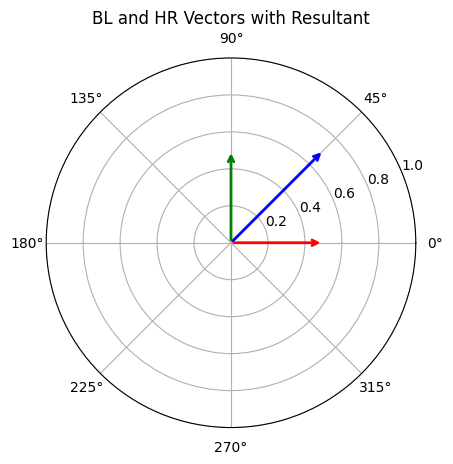

In [24]:
# Example row data (checking that the approach works as expected)
BL_input_fraction = 0.5
HR_input_fraction = 0.5
BL_angle = 0  # degrees
HR_angle = 90  # degrees

# Convert angles to radians
BL_angle_rad = np.deg2rad(BL_angle)
HR_angle_rad = np.deg2rad(HR_angle)

# Calculate x and y components for BL and HR vectors
BL_x = BL_input_fraction * np.cos(BL_angle_rad)
BL_y = BL_input_fraction * np.sin(BL_angle_rad)
HR_x = HR_input_fraction * np.cos(HR_angle_rad)
HR_y = HR_input_fraction * np.sin(HR_angle_rad)

# Compute resultant x and y components
resultant_x = BL_x + HR_x
resultant_y = BL_y + HR_y

# Convert resultant vector to polar form (magnitude and angle)
resultant_magnitude = np.sqrt(resultant_x**2 + resultant_y**2)
resultant_angle_rad = np.arctan2(resultant_y, resultant_x)

# Create a polar plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

# Plot the BL vector (from origin)
ax.annotate("", xy=(BL_angle_rad, BL_input_fraction), xytext=(0, 0),
            arrowprops=dict(arrowstyle="->", color='red', lw=2), label='BL vector')

# Plot the HR vector (from origin)
ax.annotate("", xy=(HR_angle_rad, HR_input_fraction), xytext=(0, 0),
            arrowprops=dict(arrowstyle="->", color='green', lw=2), label='HR vector')

# Plot the resultant vector (from origin)
ax.annotate("", xy=(resultant_angle_rad, resultant_magnitude), xytext=(0, 0),
            arrowprops=dict(arrowstyle="->", color='blue', lw=2), label='Resultant vector')

# Set plot labels and title
ax.set_title("BL and HR Vectors with Resultant")

plt.show()